In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import numpy as np
from plotnine import *

/Users/josh/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/josh/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Load IDs of species

In [3]:
species_id = pd.read_csv("../data/sample_genus_and_species.csv", header=0, index_col = 0)

In [4]:
species_id.head()

,genus,species,corrected genus,corrected species
CMS_001_RNA_A_S1,Culex,erythrothorax,Culex,erythrothorax
CMS_002_10a_Rb_S119_L004,Culex,quinquefasciatus,Culex,quinquefasciatus
CMS_002_13a_Rb_S120_L004,Culex,quinquefasciatus,Culex,quinquefasciatus
CMS_002_16a_Rb_S121_L004,Aedes,aegypti,Aedes,aegypti
CMS_002_17a_Rb_S122_L004,Aedes,aegypti,Aedes,aegypti


Check counts of samples in aws.

In [5]:
! aws s3 ls s3://czbiohub-mosquito/sequences/CMS002_fastq.gz/ | wc -l

     193


Check for unprocessed sequences.

In [6]:
cms002_sequences = ! aws s3 ls s3://czbiohub-mosquito/sequences/CMS002_fastq.gz/

In [7]:
suffix = '_R1_001.fastq.gz'
cms002_sequences = [x.split()[-1][:-len(suffix)] for x in cms002_sequences[1:]]
cms002_sequences[:3]

['CMS_002_10a_Rb_S119_L004',
 'CMS_002_10a_Rb_S119_L004',
 'CMS_002_13a_Rb_S120_L004']

In [8]:
suffix = '_R1_001.fastq.gz'
cms001_sequences = ! aws s3 ls s3://czbiohub-mosquito/sequences/CMS001_fastq.gz/
cms001_sequences = [x.split()[-1][:-len(suffix)] for x in cms001_sequences[1:]]
cms001_sequences[:3]

['CMS_001_RNA_A_S1', 'CMS_001_RNA_A_S1', 'CMS_002_RNA_A_S1']

In [9]:
! aws s3 ls s3://czbiohub-mosquito/references/sourmash/signatures/ | wc -l

     141


In [10]:
computed_signatures = ! aws s3 ls s3://czbiohub-mosquito/references/sourmash/signatures/
computed_signatures = [x.split()[-1].split('.')[0] for x in computed_signatures]
computed_signatures[:3]

['CMS_0015_RNA_A_S13', 'CMS_001_RNA_A_S1', 'CMS_002_10a_Rb_S119_L004']

In [12]:
needed_signatures = (set(cms001_sequences) | set(cms002_sequences)) - set(computed_signatures)
needed_signatures

{'CMS_002_45f_Rb_S189_L004',
 'CMS_002_45g_Rb_S190_L004',
 'CMS_002_46a_Rb_S191_L004',
 'CMS_002_46b_Rb_S192_L004',
 'CMS_002_47a_Rb_S193_L004',
 'CMS_002_47b_Rb_S194_L004',
 'CMS_002_47e_Rb_S197_L004',
 'CMS_002_47f_Rb_S198_L004',
 'CMS_002_47h_Rb_S1_L004',
 'CMS_002_47i_Rb_S2_L004',
 'CMS_002_47j_Rb_S3_L004',
 'CMS_002_49a_Rb_S4_L004',
 'CMS_002_4a_Rb_S117_L004',
 'CMS_002_50a_Rb_S5_L004',
 'CMS_002_51a_Rb_S6_L004',
 'CMS_002_53a_Rb_S7_L004',
 'CMS_002_54a_Rb_S8_L004',
 'CMS_002_56a_Rb_S9_L004',
 'CMS_002_57a_Rb_S10_L004',
 'CMS_002_7a_Rb_S118_L004',
 'CMS_015_RNA_A_S13',
 'CMS_017_RNA_A_S6'}

In [51]:
! aws s3 ls s3://czbiohub-mosquito/references/sourmash/comparison/

2018-09-06 08:06:35     340216 k21.csv
2018-09-06 08:06:18     319669 k21abun.csv
2018-09-06 08:09:55     342638 k31.csv
2018-09-06 08:07:59     325136 k31abun.csv
2018-09-06 08:07:02     346420 k51.csv
2018-09-06 08:09:02     324684 k51abun.csv


In [362]:
k21sim = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k21abun.csv")
k31sim = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k31abun.csv")
k51sim = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k51abun.csv")

In [363]:
k21sim_noabun = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k21.csv")
k31sim_noabun = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k31.csv")
k51sim_noabun = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k51.csv")

In [364]:
for sim in [k21sim, k31sim, k51sim, k21sim_noabun, k31sim_noabun, k51sim_noabun]:
    sim.index = sim.columns
    sim.columns = species_id.loc[sim.columns.tolist()]['corrected species'].values

/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [365]:
# Drop waters

keep = k21sim.columns.notnull()
k21sim = (k21sim[keep].transpose()[keep]).transpose()
keep = k31sim.columns.notnull()
k31sim = (k31sim[keep].transpose()[keep]).transpose()
keep = k51sim.columns.notnull()
k51sim = (k51sim[keep].transpose()[keep]).transpose()
keep = k21sim_noabun.columns.notnull()
k21sim_noabun = (k21sim_noabun[keep].transpose()[keep]).transpose()
keep = k31sim_noabun.columns.notnull()
k31sim_noabun = (k31sim_noabun[keep].transpose()[keep]).transpose()
keep = k51sim_noabun.columns.notnull()
k51sim_noabun = (k51sim_noabun[keep].transpose()[keep]).transpose()

Distances to nearest neighbors

In [344]:
def get_consensus(sim):
    neighbors = sim.columns[np.argsort(-sim.values, axis = 1)]
    consensus = pd.DataFrame({'label': neighbors[:,0].values, 'label1': neighbors[:,1].values, 'label2': neighbors[:,2].values})
    consensus.index = sim.index
    consensus['consensus1'] = (consensus['label'] == consensus['label1'])
    consensus['consensus2'] = (consensus['label'] == consensus['label1']) & (consensus['label'] == consensus['label2'])

    consensus['dist1'] = sim.values[np.arange(len(sim)),np.argsort(-sim.values, axis = 1)[:,1]]
    consensus['dist2'] = sim.values[np.arange(len(sim)),np.argsort(-sim.values, axis = 1)[:,2]]
    
    print(len(consensus), consensus['consensus1'].sum(), consensus['consensus2'].sum(), )
    return consensus

In [367]:
for sim in [k21sim, k31sim, k51sim, k21sim_noabun, k31sim_noabun, k51sim_noabun]:
    get_consensus(sim)

123 91 77
123 117 111
123 118 110
123 121 118
123 120 117
123 120 117


In [430]:
consensus = get_consensus(k51sim_noabun)

123 120 117


In [431]:
consensus.sort_values(['consensus1', 'consensus2']).head(15)

,label,label1,label2,consensus1,consensus2,dist1,dist2
CMS_012_RNA_A_S4,dorsalis,incidens,particeps,False,False,0.030849,0.030056
CMS_016_RNA_A_S6,inornata,incidens,particeps,False,False,0.053663,0.052263
CMS_040_RNA_A_S21,tarsalis,erythrothorax,erythrothorax,False,False,0.050395,0.047651
CMS_044_RNA_A_S22,pipiens,pipiens,erythrothorax,True,False,0.000210,0.000197
CMS_060_RNA_A_S12,inornata,inornata,particeps,True,False,0.048081,0.026238
CMS_014_RNA_A_S5,incidens,incidens,particeps,True,False,0.077243,0.057095
CMS_041_RNA_A_S10,pipiens,pipiens,pipiens,True,True,0.071766,0.064208
CMS_002_44d_Rb_S181_L004,aegypti,aegypti,aegypti,True,True,0.108231,0.106308
CMS_002_17d_Rb_S125_L004,aegypti,aegypti,aegypti,True,True,0.096828,0.092170
CMS_054_RNA_A_S11,pipiens,pipiens,pipiens,True,True,0.053732,0.052860


/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:90: UserWarning: 'stat_bin()' using 'bins = 14'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and w

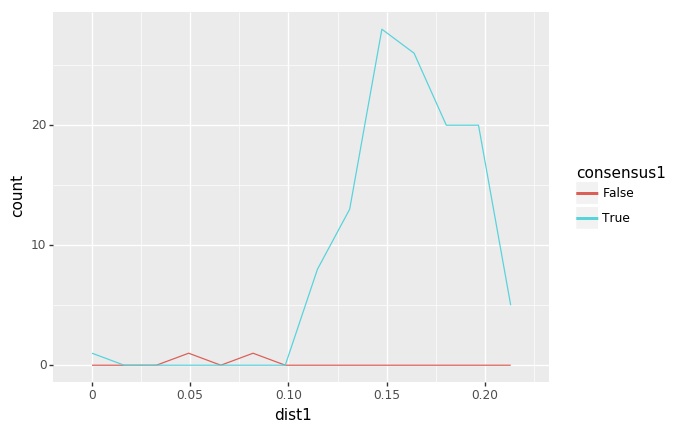

<ggplot: (-9223372029176044789)>

In [405]:
ggplot(consensus, aes(x = 'dist1', color='consensus1')) + geom_freqpoly()

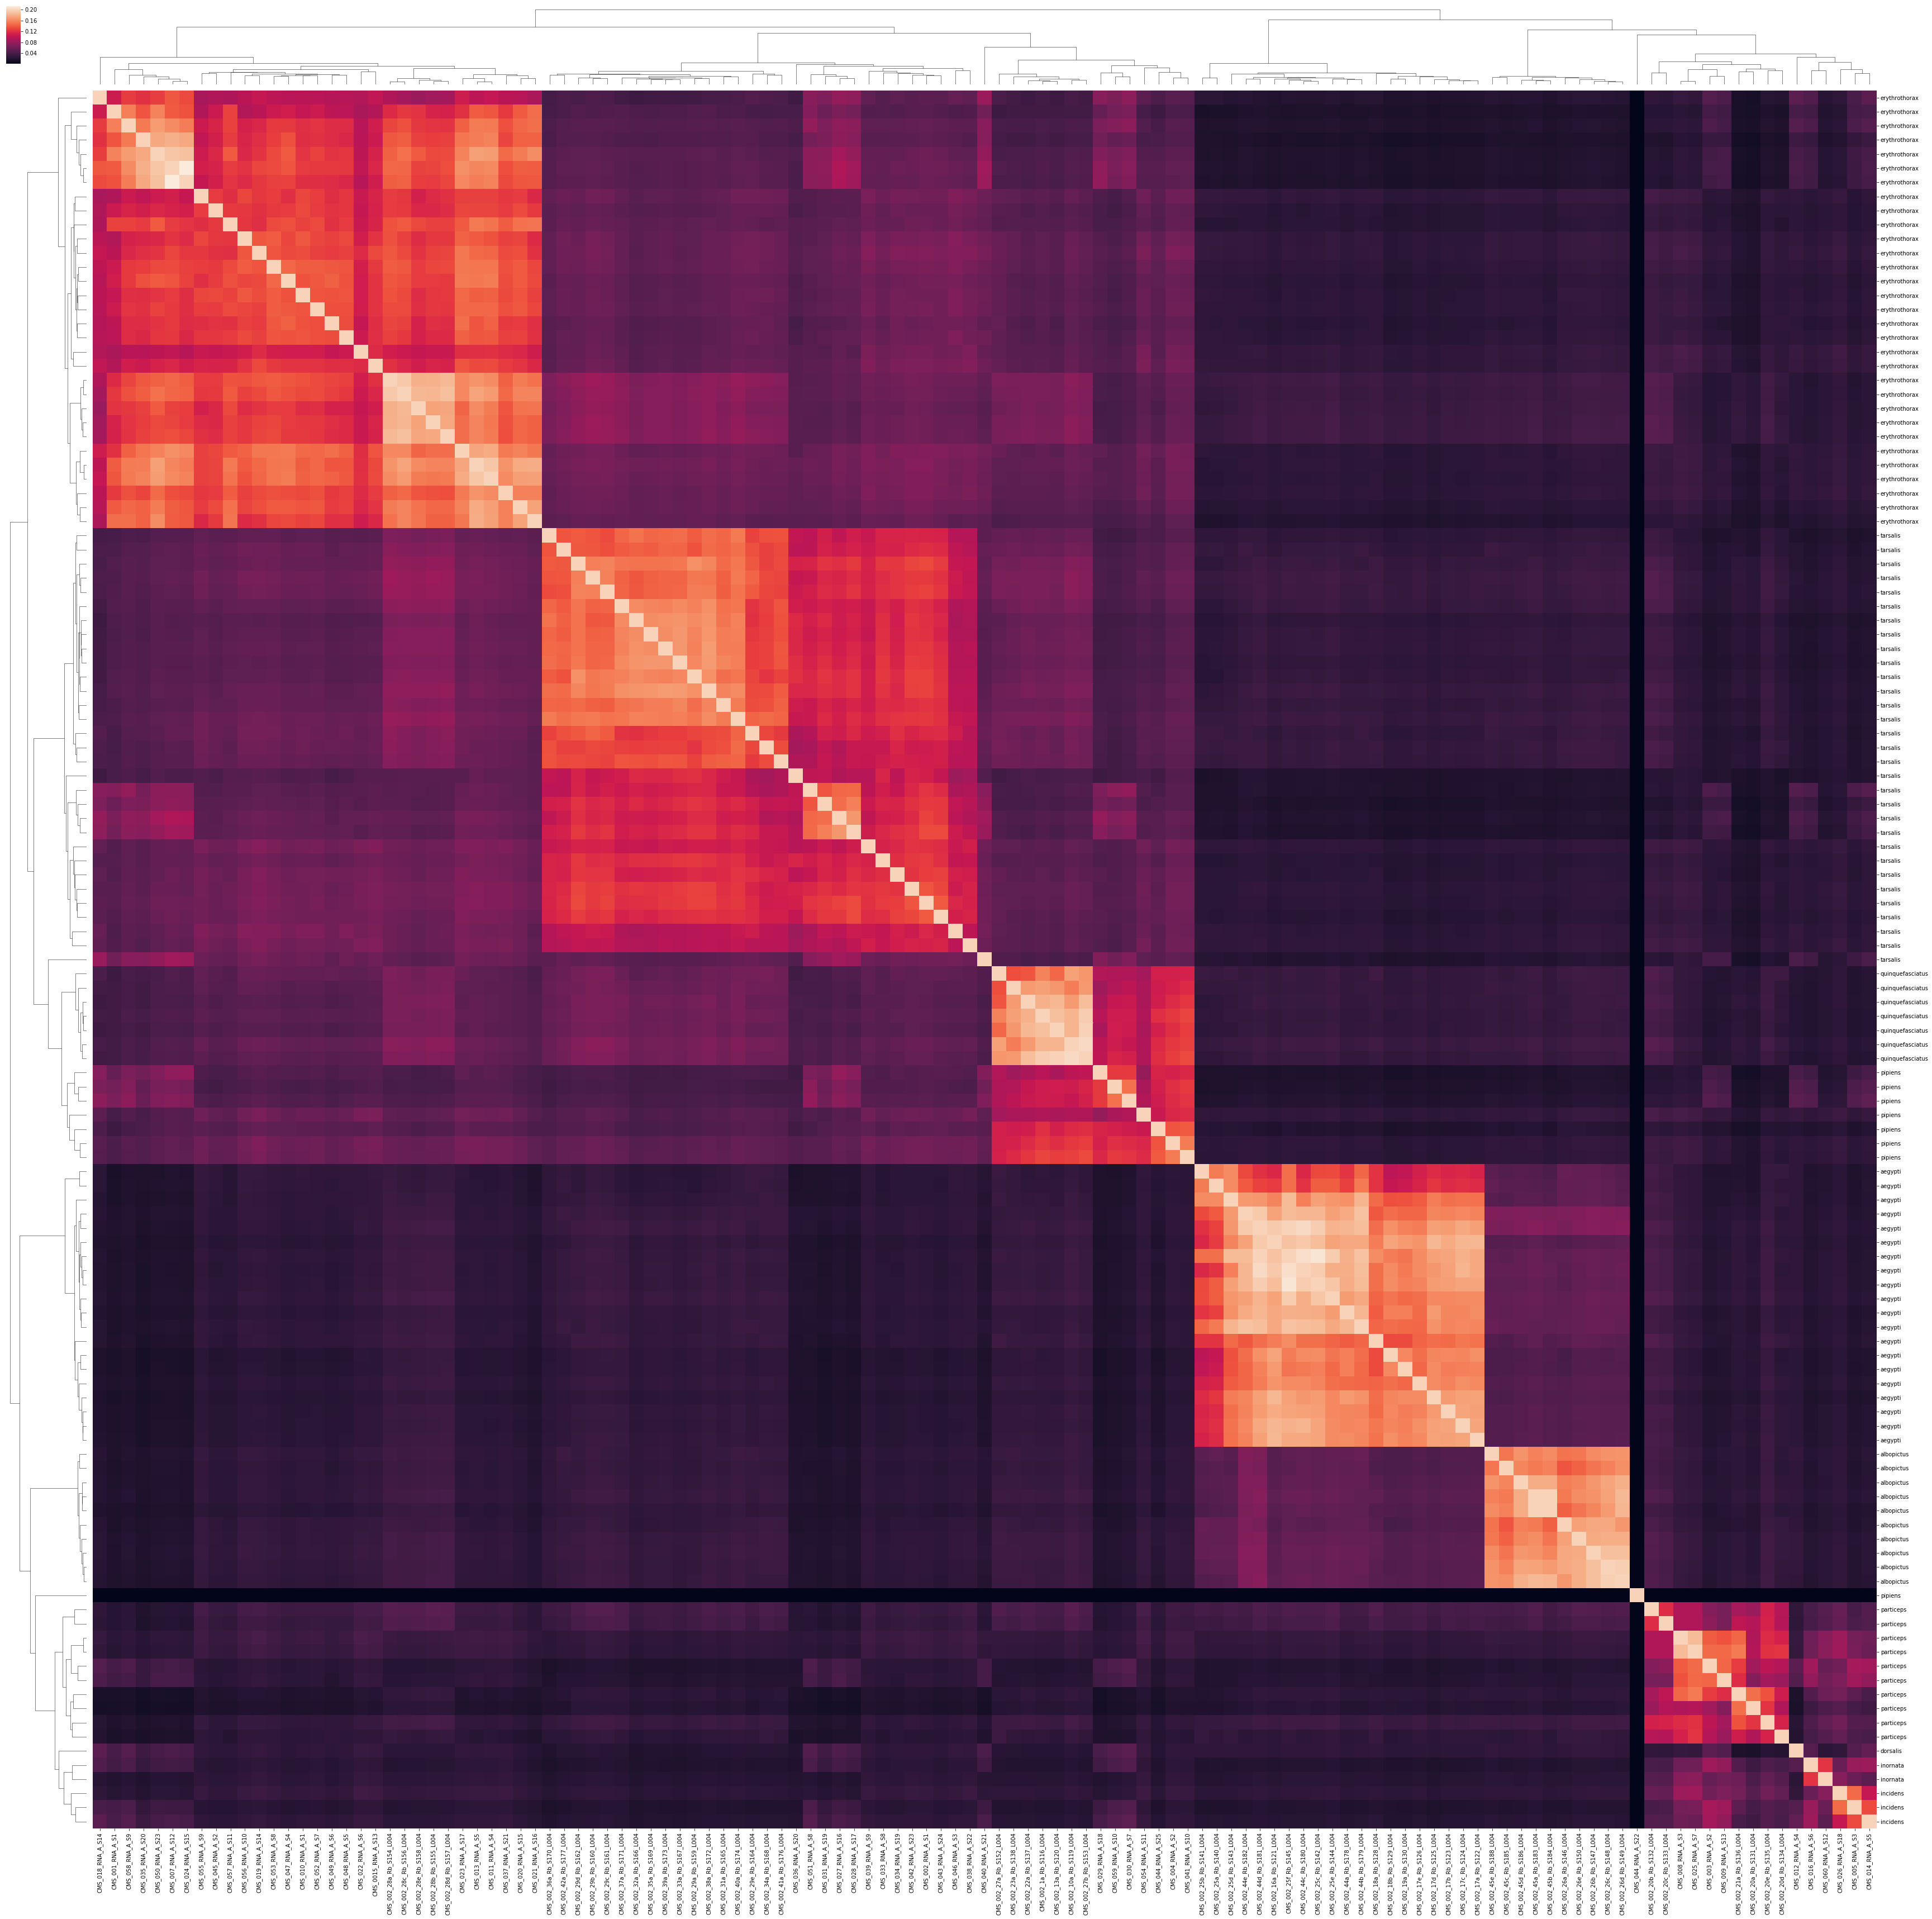

In [414]:
sns.clustermap(k21sim_noabun.transpose() - np.eye(len(k21sim_noabun))*0.8,  figsize = (60,60))

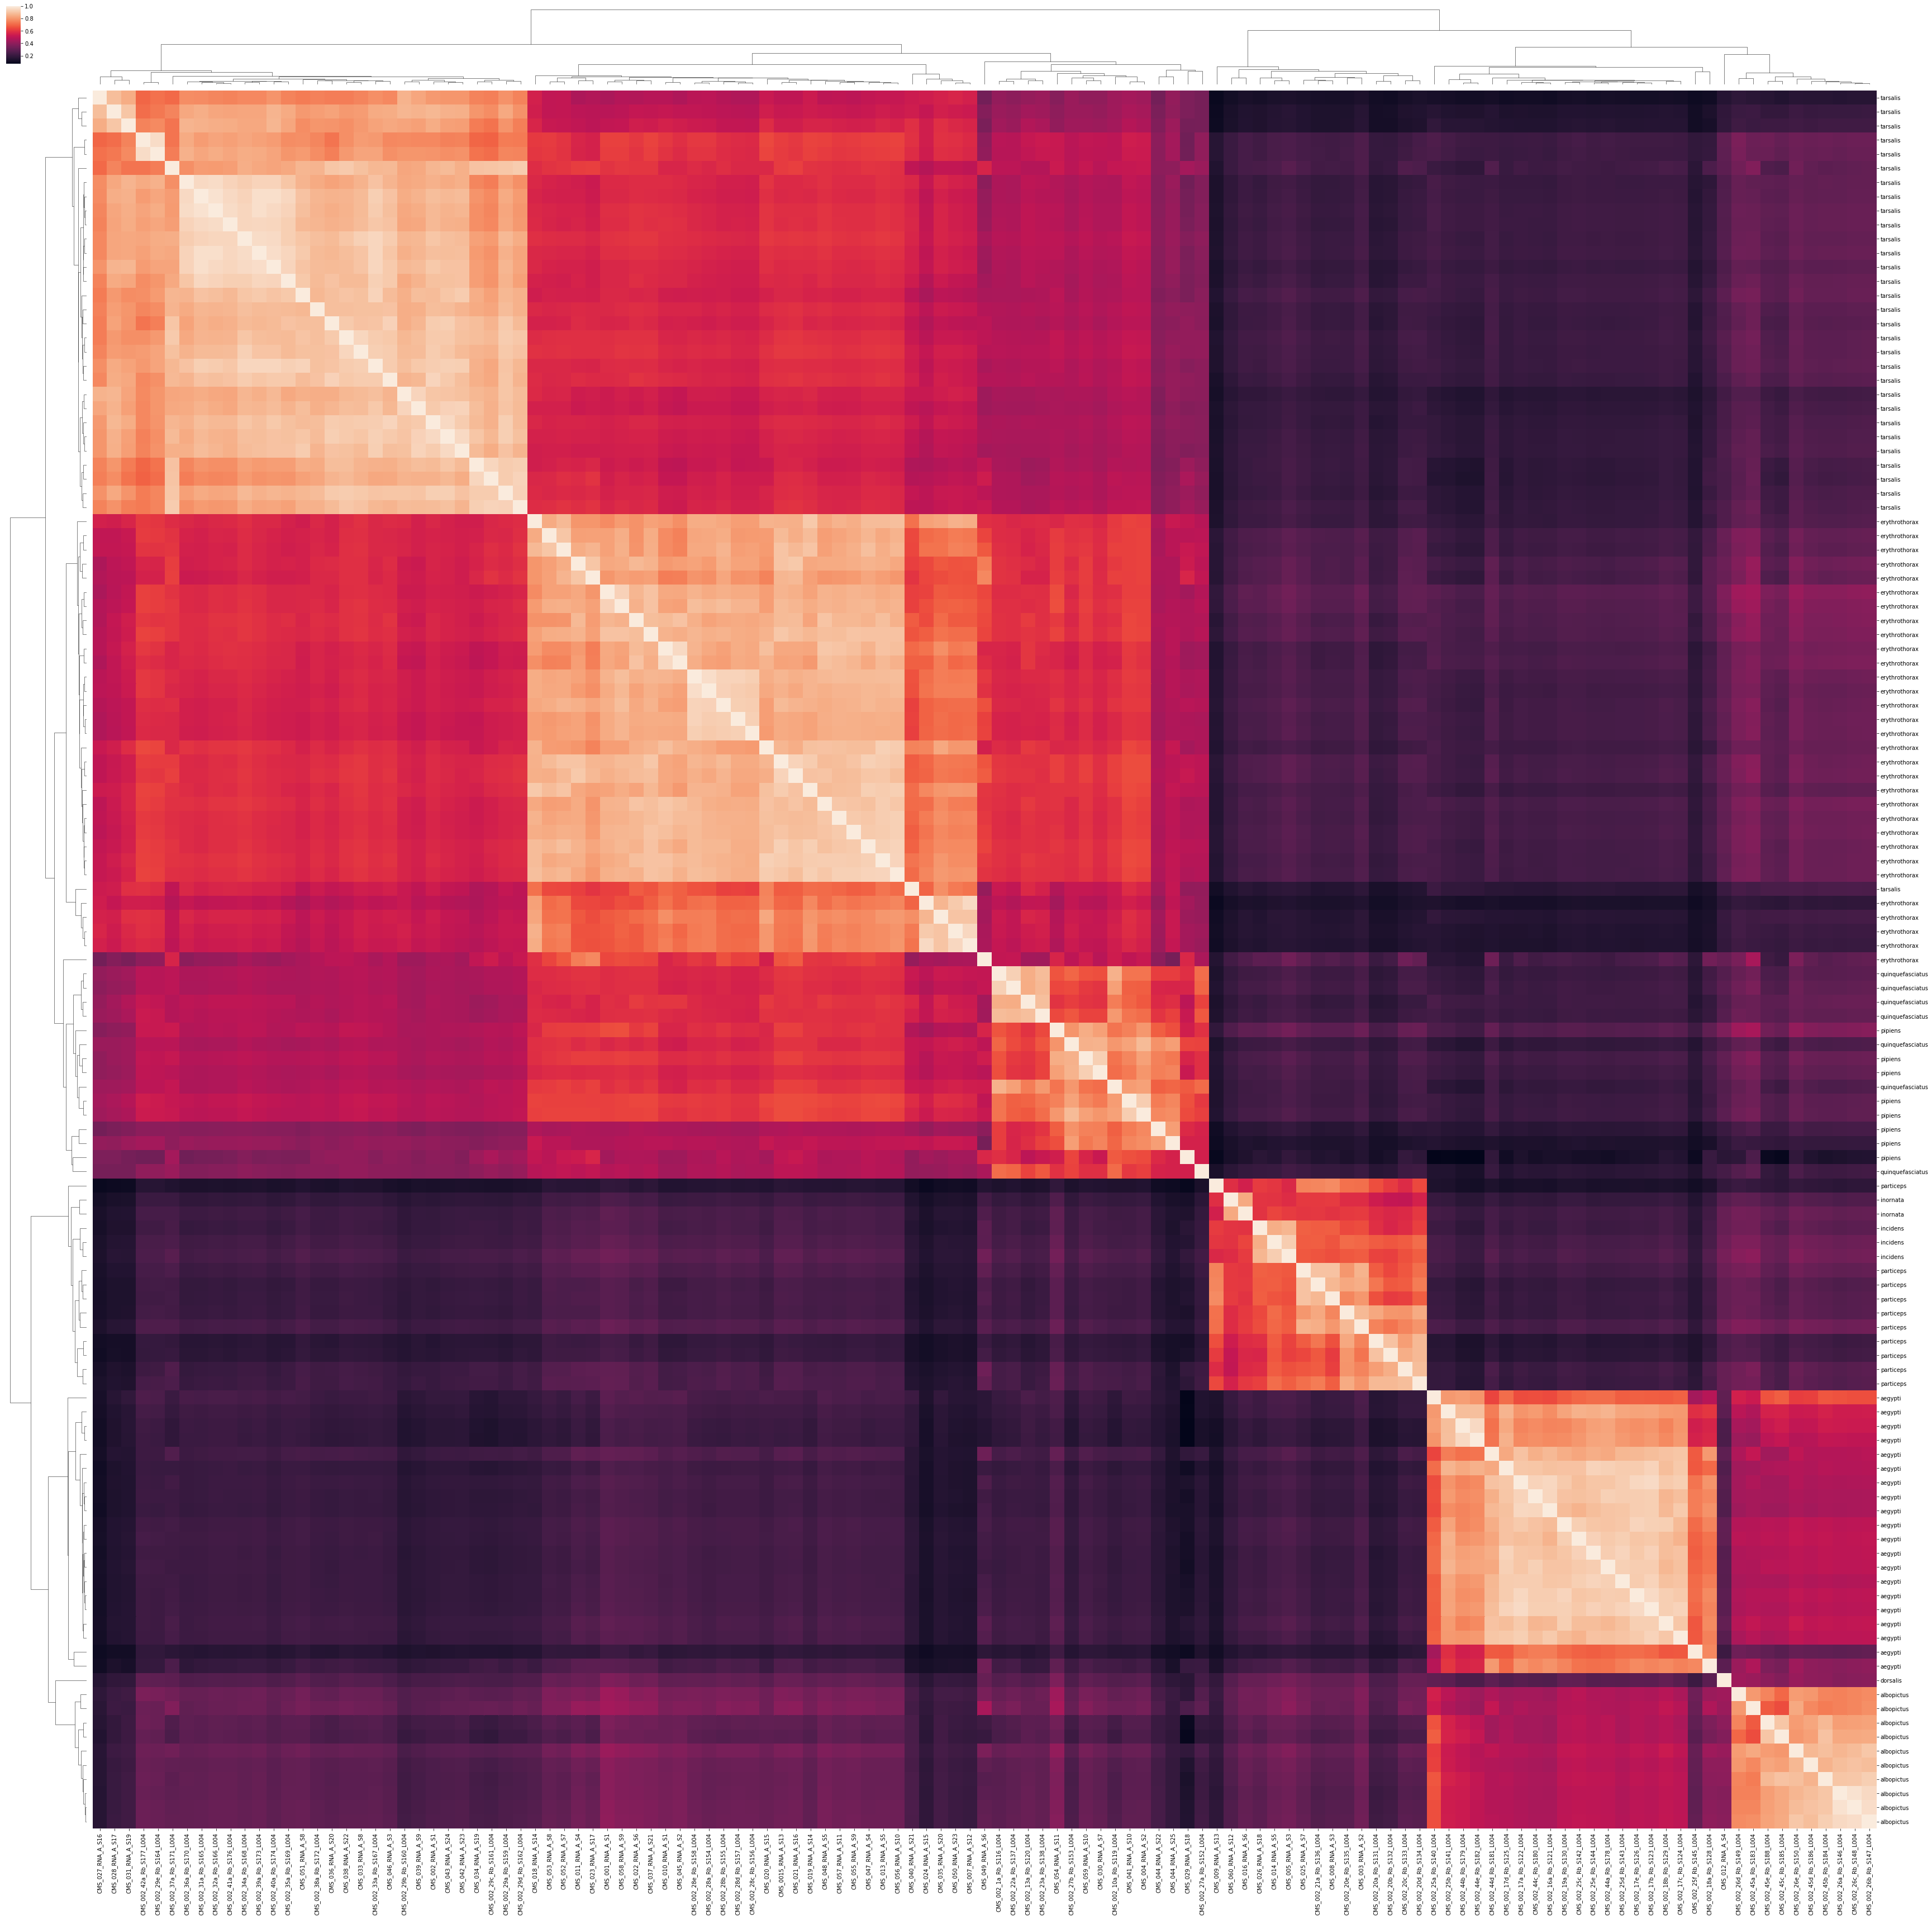

In [366]:
sns.clustermap(k51sim.transpose(),  figsize = (60,60))

Zoom to quinquefasciatus, pipiens cluster:

In [ ]:
CMS_002_27b_Rb_S153_L004 likely pipiens at 21 and 51, but not at 31

CMS_029_RNA_A_S18 distant from all pip, q.
CMS_044_RNA_A_S25 distant from other pip, including the other CMS_044_RNA_A_S22
CMS_002_10a_Rb_S119_L004 q is distant from all others
CMS_044_RNA_A_S22 distant from others (k 31)

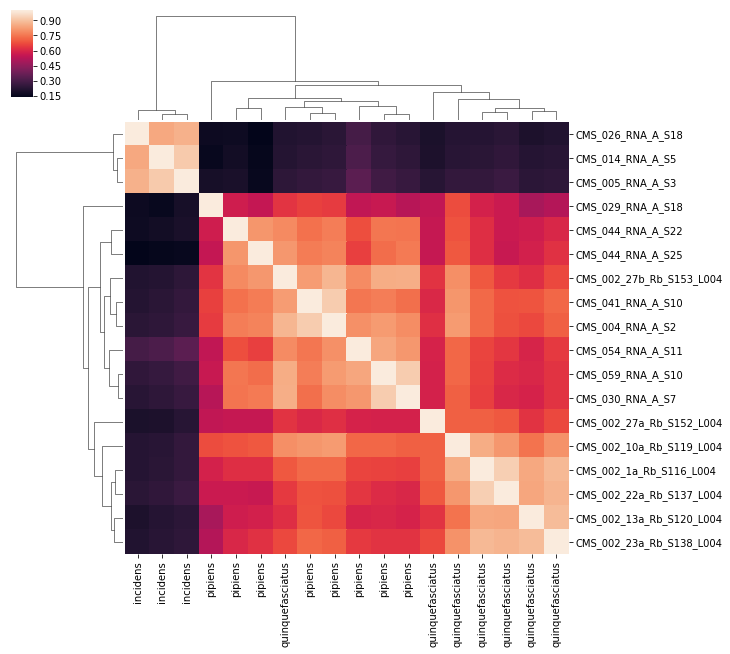

In [353]:
sim = k51sim
isqp = sim.columns.isin(['quinquefasciatus', 'pipiens','incidens'])
sns.clustermap(sim[isqp].transpose()[isqp].transpose(),  figsize = (10,10))

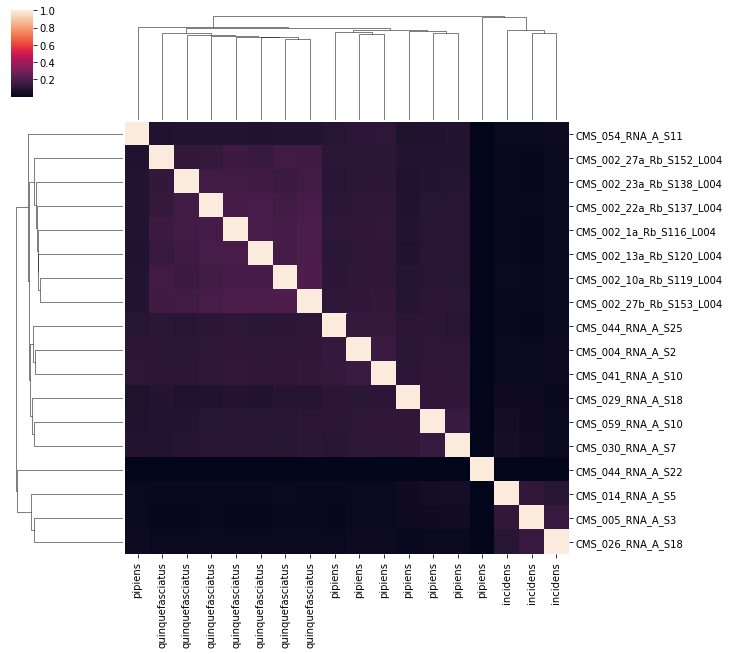

In [415]:
sim = k21sim_noabun
isqp = sim.columns.isin(['quinquefasciatus', 'pipiens','incidens'])
sns.clustermap(sim[isqp].transpose()[isqp].transpose(),  figsize = (10,10))

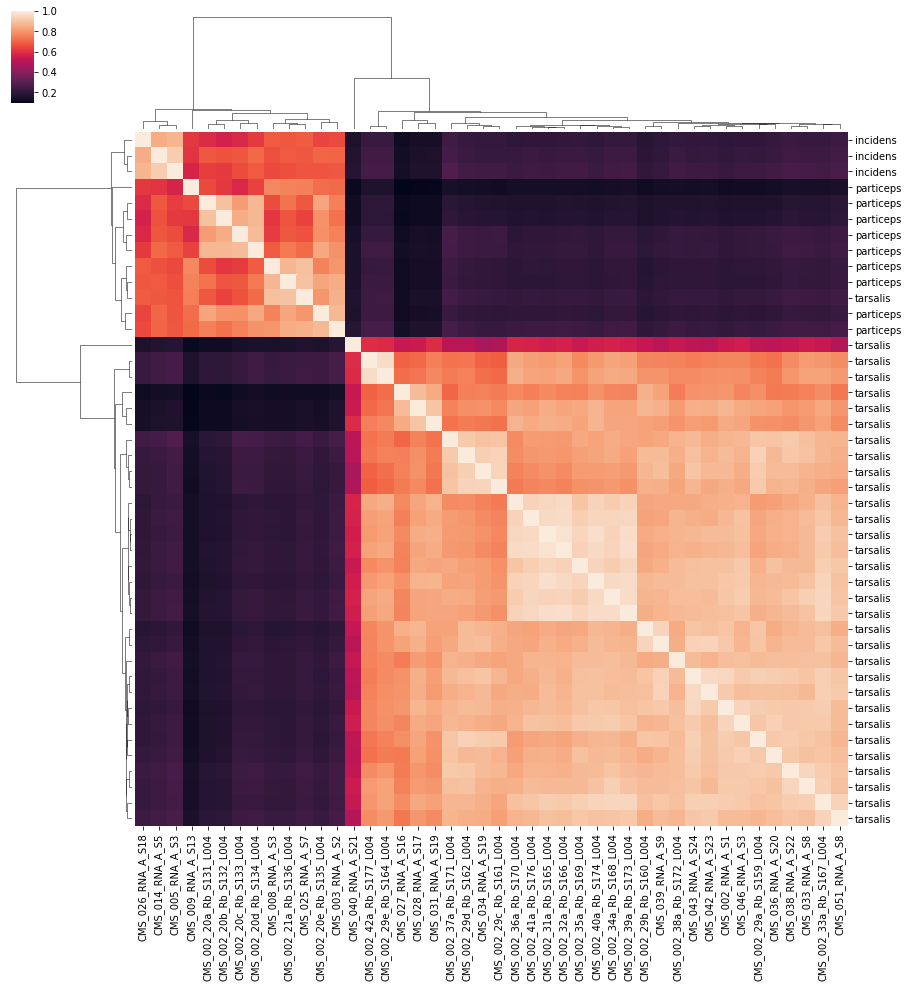

In [334]:
sim = k51sim
isqp = sim.columns.isin(['tarsalis','incidens', 'particeps'])
sns.clustermap(sim[isqp].transpose()[isqp],  figsize = (15,15))